### Assignment 3 with mobilenet

In [26]:
from PIL import Image
import pillow_heif
pillow_heif.register_heif_opener()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import json
import numpy as np
import matplotlib.pyplot as plt

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU Available: []


In [27]:
dataset_path = 'E:/Others/Machine Learning/Python-venv/studentdata'

batch_size = 32
img_height = 224
img_width = 224
epochs_initial = 10
epochs_fine_tune = 10

num_classes = len(os.listdir(dataset_path))
print(f"Total number of students (classes): {num_classes}")
print(f"Expected images: {num_classes * 20}")

Total number of students (classes): 79
Expected images: 1580


In [28]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

print("Data generators created!")

Data generators created!


In [29]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 1216 images belonging to 79 classes.
Found 281 images belonging to 79 classes.

Training samples: 1216
Validation samples: 281


In [30]:
print("Class indices (Student ID -> Index):")
class_items = list(train_generator.class_indices.items())
for i, (student_id, idx) in enumerate(class_items[:10]):
    print(f"  {student_id} -> {idx}")
print(f"  ... and {len(class_items) - 10} more")

with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)
print("\nClass indices saved to 'class_indices.json'")

Class indices (Student ID -> Index):
  21-45902-3 -> 0
  22-46138-1 -> 1
  22-46139-1 -> 2
  22-46141-1 -> 3
  22-46156-1 -> 4
  22-46258-1 -> 5
  22-46275-1 -> 6
  22-46293-1 -> 7
  22-46342-1 -> 8
  22-46473-1 -> 9
  ... and 69 more

✓ Class indices saved to 'class_indices.json'


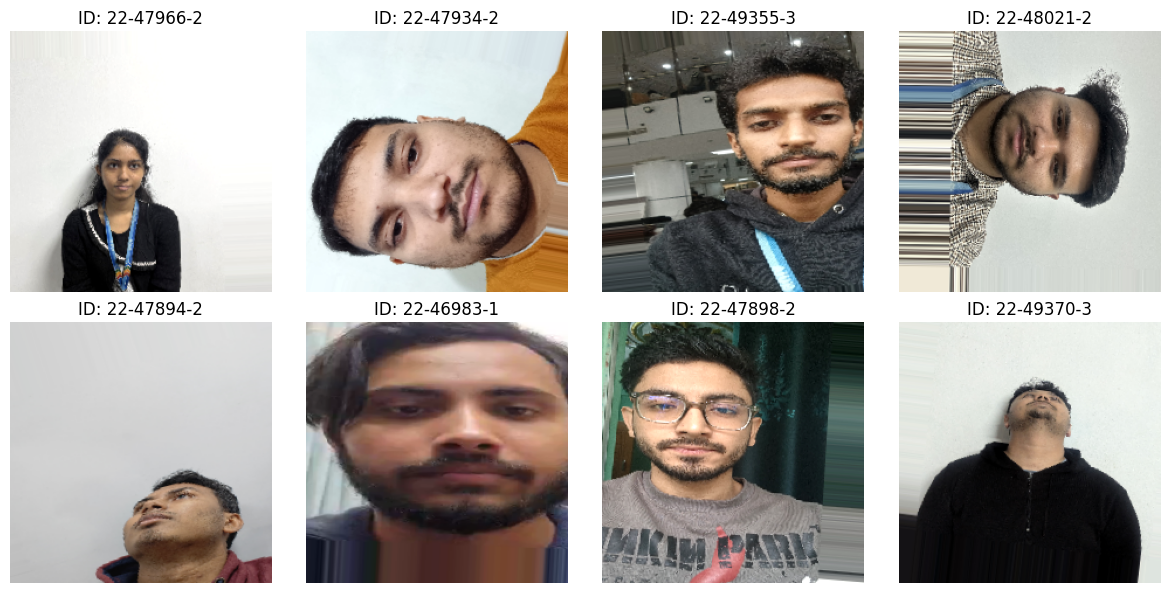

In [31]:
sample_batch, sample_labels = next(train_generator)

def deprocess_image(img):
    img = img.copy()
    img += 1.0
    img *= 127.5
    return img.astype('uint8')

plt.figure(figsize=(12, 6))
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(deprocess_image(sample_batch[i]))
    label_idx = np.argmax(sample_labels[i])
    plt.title(f"ID: {index_to_class[label_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

print("Model built successfully!")
print(f"\nBase model layers: {len(base_model.layers)}")
print(f"Total parameters: {model.count_params():,}")

✓ Model built successfully!

Base model layers: 154
Total parameters: 2,634,127


In [33]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224          │ (None, 7, 7, 1280)    │    2,257,984 │
│ (Functional)                  │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d_2    │ (None, 1280)          │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_2         │ (None, 1280)          │        5,120 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_4 (Dense)               │ (None, 256)           │      327,936 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_2 (Dropout)           │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_5 (Dense)               │ (None, 128)           │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_3 (Dropout)           │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_6 (Dense)               │ (None, 79)            │       10,191 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 2,634,127 (10.05 MB)

 Trainable params: 373,583 (1.43 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)
print("Model compiled!")
print("Callbacks ready!")

✓ Model compiled!
✓ Callbacks ready!


In [35]:
print("PHASE 1: Training with frozen base model")

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_initial,
    callbacks=[early_stopping, reduce_lr]
)

PHASE 1: Training with frozen base model
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.0748 - loss: 4.2807 - val_accuracy: 0.3808 - val_loss: 3.5556 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3141 - loss: 2.8504 - val_accuracy: 0.6085 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5041 - loss: 1.9836 - val_accuracy: 0.7402 - val_loss: 1.4916 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6168 - loss: 1.4782 - val_accuracy: 0.8185 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6571 - loss: 1.2583 - val_accuracy: 0.8114 - val_loss: 0.7821 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7245 - loss: 1.0374 - val_accuracy: 0.8434 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accurac

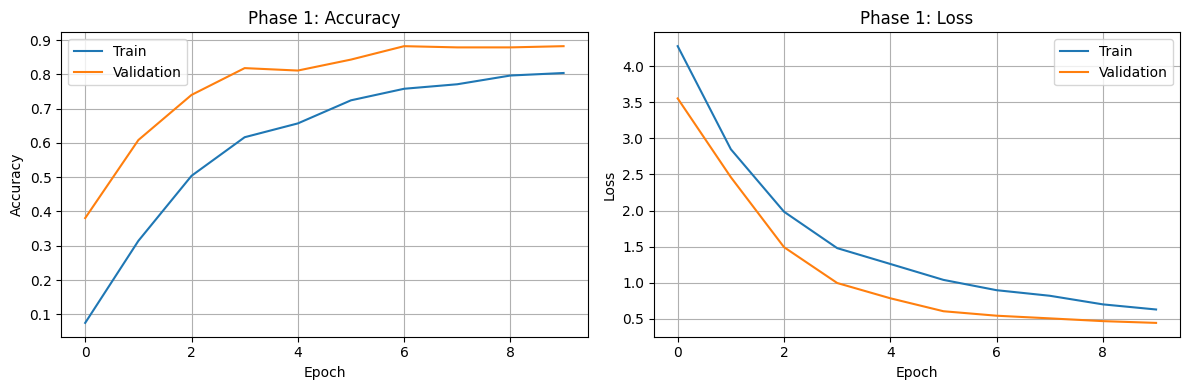


Phase 1 Best Validation Accuracy: 88.26%


In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Phase 1: Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)


ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Phase 1: Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nPhase 1 Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")

In [37]:
print("PHASE 2: Fine-tuning with unfrozen layers")


base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_layers}")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled for fine-tuning!")

PHASE 2: Fine-tuning with unfrozen layers
Trainable layers in base model: 54
✓ Model recompiled for fine-tuning!


In [38]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_fine_tune,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6192 - loss: 1.4318 - val_accuracy: 0.8505 - val_loss: 0.6359 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7451 - loss: 0.8426 - val_accuracy: 0.8043 - val_loss: 0.8081 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8240 - loss: 0.6022 - val_accuracy: 0.8149 - val_loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8363 - loss: 0.5770 - val_accuracy: 0.8185 - val_loss: 0.7269 - learning_rate: 2.0000e-05
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8487 - loss: 0.5065 - val_accuracy: 0.8185 - val_loss: 0.7317 - learning_rate: 2.0000e-05


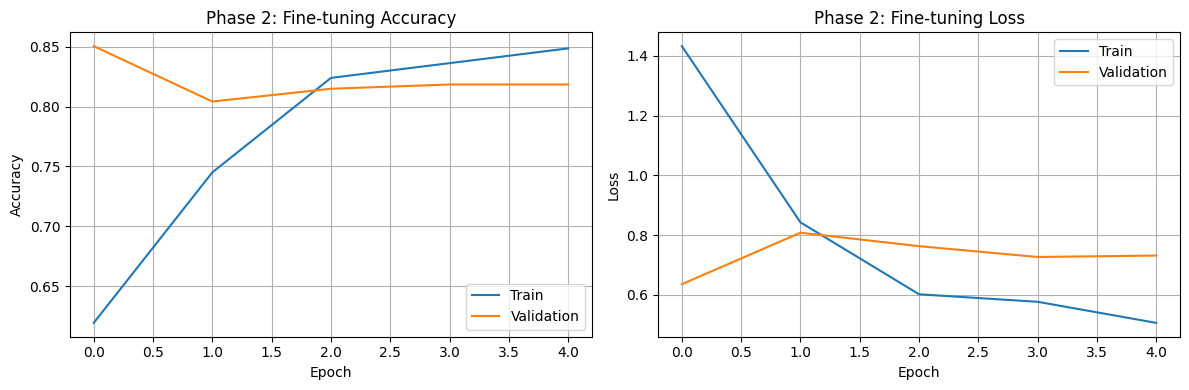


Phase 2 Best Validation Accuracy: 85.05%


In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(fine_tune_history.history['accuracy'], label='Train')
ax1.plot(fine_tune_history.history['val_accuracy'], label='Validation')
ax1.set_title('Phase 2: Fine-tuning Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(fine_tune_history.history['loss'], label='Train')
ax2.plot(fine_tune_history.history['val_loss'], label='Validation')
ax2.set_title('Phase 2: Fine-tuning Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nPhase 2 Best Validation Accuracy: {max(fine_tune_history.history['val_accuracy'])*100:.2f}%")

In [40]:
print("FINAL EVALUATION")

final_loss, final_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {final_loss:.4f}")
print(f"Validation Accuracy: {final_accuracy * 100:.2f}%")

FINAL EVALUATION
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8505 - loss: 0.6359

Validation Loss: 0.6359
Validation Accuracy: 85.05%


In [42]:
model.save('student_recognition_mobilenet.h5')
print("Model saved as 'student_recognition_mobilenet.h5'")


✓ Model saved as 'student_recognition_mobilenet.h5'


In [43]:
from tensorflow.keras.preprocessing import image

with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}

def predict_student(img_path):
    """Predict student ID from image path"""
    # Load and preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100
    
    student_id = index_to_class[predicted_index]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {student_id}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    
    return student_id, confidence

print("Prediction function ready!")

✓ Prediction function ready!

Usage: predict_student('path/to/image.jpg')


In [ ]:
##### 2=Student_TL_FACE 